In [4]:

import sagemaker

session = sagemaker.Session()

bucket = session.default_bucket()
prefix = "deepar-retail"
file_path = "csvjson.json"

train_input = session.upload_data("train_deepar.json", bucket=bucket, key_prefix=prefix)
print("File uploaded to:", train_input)


File uploaded to: s3://sagemaker-us-east-1-127214195305/deepar-retail/train_deepar.json


In [6]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
import boto3
import sagemaker

region = boto3.Session().region_name

image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", region)



role = get_execution_role()
region = boto3.Session().region_name

image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", region)

estimator = Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    output_path=f"s3://{bucket}/{prefix}/output",
    sagemaker_session=session
)

estimator.set_hyperparameters(
    time_freq="D",  # "D" for daily data
    context_length=14,
    prediction_length=7,
    epochs=20,
    early_stopping_patience=3,
    mini_batch_size=32,
    learning_rate=0.001
)


In [7]:
estimator.fit({"train": train_input})


INFO:sagemaker:Creating training-job with name: forecasting-deepar-2025-06-07-06-43-44-478


2025-06-07 06:43:46 Starting - Starting the training job...
2025-06-07 06:44:01 Starting - Preparing the instances for training...
2025-06-07 06:44:21 Downloading - Downloading input data...
2025-06-07 06:45:01 Downloading - Downloading the training image............
2025-06-07 06:47:08 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[06/07/2025 06:47:15 INFO 140354721535808] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 

In [8]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large"
)


INFO:sagemaker:Creating model with name: forecasting-deepar-2025-06-07-06-50-23-253
INFO:sagemaker:Creating endpoint-config with name forecasting-deepar-2025-06-07-06-50-23-253
INFO:sagemaker:Creating endpoint with name forecasting-deepar-2025-06-07-06-50-23-253


--------!

In [9]:
predictor.endpoint_name


'forecasting-deepar-2025-06-07-06-50-23-253'

In [16]:
import json

payload = {
    "instances": [
        {
            "start": "2023-01-01",  # your actual start date
            "target": [100, 120, 130, 110, 150, 170, 180]  # replace with your real data
        }
    ],
    "configuration": {
        "num_samples": 50,
        "output_types": ["quantiles"],
        "quantiles": ["0.1", "0.5", "0.9"]
    }
}

response = predictor.predict(
    json.dumps(payload),
    initial_args={"ContentType": "application/json"}
)



In [17]:
import json

forecast = json.loads(response)

# Extract the quantile forecasts
p10 = forecast["predictions"][0]["quantiles"]["0.1"]
p50 = forecast["predictions"][0]["quantiles"]["0.5"]
p90 = forecast["predictions"][0]["quantiles"]["0.9"]


In [18]:
# Use the same input as the prediction request
past_series = payload["instances"][0]["target"]
prediction_length = len(p50)
x = list(range(len(past_series) + prediction_length))


/tmp/ipykernel_20959/1485236610.py:47: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_20959/1485236610.py:47: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_20959/1485236610.py:47: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing fro

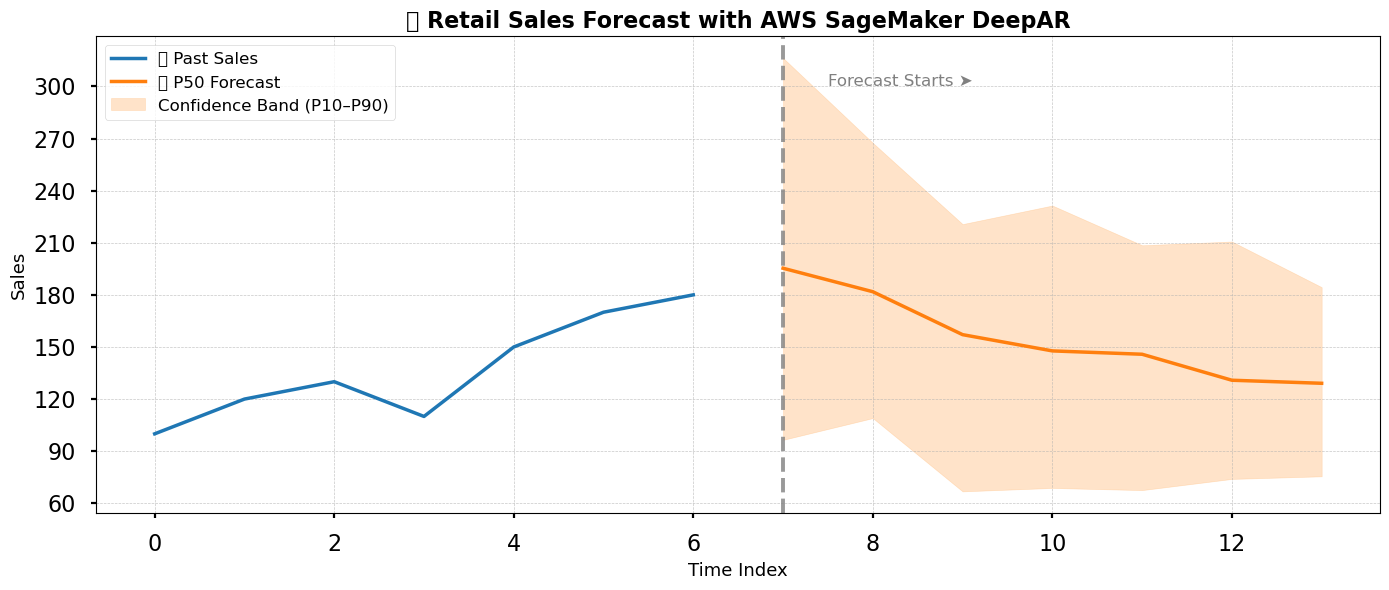

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Set modern style
plt.style.use("seaborn-v0_8-poster")

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# X-axis range
x_range = list(range(len(past_series) + prediction_length))

# Plot past data
ax.plot(range(len(past_series)), past_series, label="📘 Past Sales", color="#1f77b4", linewidth=2.5)

# Plot P50 forecast
forecast_start = len(past_series)
ax.plot(range(forecast_start, forecast_start + prediction_length), p50, label="🔮 P50 Forecast", color="#ff7f0e", linewidth=2.5)

# Fill confidence interval (P10–P90)
ax.fill_between(
    range(forecast_start, forecast_start + prediction_length),
    p10, p90,
    color="#ffbb78",
    alpha=0.4,
    label="Confidence Band (P10–P90)"
)

# Vertical line at forecast start
ax.axvline(x=forecast_start, color='gray', linestyle='--', alpha=0.8)
ax.text(forecast_start + 0.5, max(p90)*0.95, "Forecast Starts ➤", fontsize=12, color='gray')

# Titles and labels
ax.set_title("📊 Retail Sales Forecast with AWS SageMaker DeepAR", fontsize=16, weight='bold')
ax.set_xlabel("Time Index", fontsize=13)
ax.set_ylabel("Sales", fontsize=13)

# Format y-axis
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Customize grid and legend
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(loc="upper left", fontsize=12)

# Tight layout
plt.tight_layout()
plt.show()
